# <span style="color:blue;">The Lennard-Jones Potential</span>

The **Lennard-Jones (LJ) potential** describes the interaction between two neutral particles, such as atoms or molecules, and is widely used in simulations of particle systems, including molecular dynamics. The LJ potential is expressed as:

$$
U(r) = 4\epsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right]
$$

Where:  
- **$r$**: <span style="color:green;">Distance between two particles</span>.  
- **$\epsilon$**: <span style="color:purple;">Depth of the potential well</span>, representing the strength of attractive forces.  
- **$\sigma$**: <span style="color:orange;">Distance at which the potential is zero</span>, roughly corresponding to the effective size of the particles.

---

## <span style="color:red;">Motivation for Simulating Particles in 3D with LJ Potential</span>

In a 3D box, particles interact with one another via the **Lennard-Jones potential**, which models their mutual attraction and repulsion. This is essential for studying phenomena such as:
- **Condensed phases**: Formation of liquids and solids from gases.  
- **Intermolecular forces**: Stabilization of particle clusters through van der Waals interactions.  
- **Thermodynamic properties**: Understanding energy, pressure, and phase transitions at the molecular level.  
- **Microscopic behavior**: Simulating realistic dynamics, such as diffusion and collisions.

The **LJ potential** offers a computationally efficient way to capture these phenomena without explicitly modeling quantum effects.

---

## <span style="color:teal;">Shape of the Potential</span>

1. 🔴 **Repulsive region** ($r \ll \sigma$):  
   - The $(\sigma/r)^{12}$ term dominates, and the potential becomes sharply **repulsive**.  
   - Prevents particles from overlapping by modeling electron cloud repulsion.

2. 🟠 **Attractive region** ($r > \sigma$):  
   - The $(\sigma/r)^6$ term dominates, creating weak **van der Waals attractions**.  
   - Stabilizes particle clusters at a distance close to $r_{\text{min}}$.

3. 🟢 **Equilibrium distance** ($r_{\text{min}} = 2^{1/6} \sigma \approx 1.122 \sigma$):  
   - The point of **minimum potential energy** where the attractive and repulsive forces balance.  
   - This is the most stable particle-pair separation.

---

## <span style="color:darkblue;">Physical Significance of LJ Parameters</span>

- **$\epsilon$** (Well Depth):  
  Controls the strength of attraction between particles.  
  - A **large $\epsilon$** leads to stronger binding and higher stability.  
  - A **small $\epsilon$** models weaker interactions.

- **$\sigma$** (Zero Potential Distance):  
  Sets the effective size of the particles.  
  - Determines the distance where repulsion transitions to attraction.

- **$r_{\text{min}}$**:  
  The most stable distance where particles naturally settle if no external forces act.

---

## <span style="color:darkred;">Visualization of the Potential Well</span>

The potential well illustrates the balance of forces:
- **Steep rise** on the left: Strong repulsion when particles approach too closely.  
- **Dip at $r_{\text{min}}$**: Most stable configuration with maximum attraction.  
- **Gradual return to zero**: Weak attractions at large separations.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters (constants defining the system)
L = 20.0  # Length of the simulation box (assumed cubic, so it's L x L x L).
N = 60  # Number of particles in the simulation.
T = 1.0  # Temperature of the system (used to initialize velocities).
sigma = 1.0  # Lennard-Jones parameter for distance scale.
epsilon = 1.0  # Lennard-Jones parameter for energy scale (depth of the potential well).
mass = 1.0  # Mass of each particle (assumed uniform for simplicity and practice).
rcut = 2.5 * sigma  # Cutoff distance for the Lennard-Jones potential.
dt = 1/400 * (mass * sigma**2 / epsilon)**0.5  # Time step for integration (small steps ensure accuracy).
#T_vib = 2 * 22/7 * (mass * sigma**2 / epsilon)**0.5
#dt = 1/20 * T_vib

'''
The time step (dt) must be small enough to accurately integrate the equations of motion 
without introducing instabilities or energy conservation errors. So it is important to 
introduce a stability check (like energy conservation) in the code.

Rule of Thumb for Choosing Time Step (dt) ---
    To consult with Dr Shivraj
    
'''
steps = 2000  # Number of simulation steps to run.

# **Example to Illustrate Periodic Boundary Conditions (PBC)**

Suppose the simulation box has a length $L = 10$, and the particle positions are initially:

$$
\text{positions} = 
\begin{bmatrix}
-6 & 4 & 8 \\
5 & -11 & 12
\end{bmatrix}
$$

---

## **Without PBC**
- The particle at $(-6, 4, 8)$ lies outside the lower x-boundary ($-L/2 = -5$).
- The particle at $(5, -11, 12)$ exceeds the y and z boundaries ($-L/2 = -5$ and $L/2 = 5$).
- Without PBC, these particles are considered **"out of bounds"** or interact incorrectly.

---

## **With PBC**

### Step 1: Shift to $[0, L]$  
Add $L/2 = 5$ to shift the box range from $[-L/2, L/2]$ to $[0, L]$:

$$
\begin{bmatrix}
-6 + 5 & 4 + 5 & 8 + 5 \\
5 + 5 & -11 + 5 & 12 + 5
\end{bmatrix}
=
\begin{bmatrix}
-1 & 9 & 13 \\
10 & -6 & 17
\end{bmatrix}
$$

---

### Step 2: Wrap using modulo $L = 10$  
Apply the modulo operation to "wrap" the positions back into the $[0, L]$ range:

$$
\begin{bmatrix}
-1 \% 10 & 9 \% 10 & 13 \% 10 \\
10 \% 10 & -6 \% 10 & 17 \% 10
\end{bmatrix}
=
\begin{bmatrix}
9 & 9 & 3 \\
0 & 4 & 7
\end{bmatrix}
$$

---

### Step 3: Shift back to $[-L/2, L/2]$  
Subtract $L/2 = 5$ to shift the box back to its original range:

$$
\begin{bmatrix}
9 - 5 & 9 - 5 & 3 - 5 \\
0 - 5 & 4 - 5 & 7 - 5
\end{bmatrix}
=
\begin{bmatrix}
4 & 4 & -2 \\
-5 & -1 & 2
\end{bmatrix}
$$

---

## **Final Positions**
After applying PBC, all particles are now within the valid range $[-L/2, L/2]$:

$$
\begin{bmatrix}
4 & 4 & -2 \\
-5 & -1 & 2
\end{bmatrix}
$$

---

- **Without PBC:** Particles outside $[-L/2, L/2]$ violate boundary conditions, leading to unrealistic behavior.  
- **With PBC:** Particles wrap seamlessly to the opposite side, simulating an **infinite system with periodic repeats**.


In [2]:
# --- PBC Function ---
def apply_pbc(positions, L):
    """
    Applies periodic boundary conditions (PBC) to particle positions.
    
    Ensures particles that move outside the box boundaries are "wrapped" back into the box,
    creating the effect of an infinite, repeating system.

    Parameters:
    - positions: A numpy array of shape (N, 3), where N is the number of particles.
      Each row represents the (x, y, z) coordinates of a particle.
    - L: The side length of the cubic simulation box.

    Returns:
    - A numpy array of the same shape as `positions`, where all particles are wrapped
      into the range [-L/2, L/2].
    """
    # Shift positions to temporarily move the box boundaries from [-L/2, L/2] to [0, L]
    # This step ensures the modulo operation works correctly.
    shifted_positions = positions + L / 2
    # Apply modulo operation to wrap particles back into the box range [0, L]
    wrapped_positions = shifted_positions % L
    # Shift the box back to its original range of [-L/2, L/2]
    centered_positions = wrapped_positions - L / 2
    return centered_positions

    '''
    Alternative implementation:
    def apply_pbc(positions):
        return positions - L * np.round(positions / L)
    '''

<div style="font-family:verdana; line-height:1.4;">

# <span style="color:#2E8B57;">Initialization Methods in Molecular Dynamics</span>

In <span style="color:#4682B4;"><strong>Molecular Dynamics (MD)</strong></span> simulations, the <em>initial positions</em> of the particles are crucial. A well-chosen initial configuration can:

- <span style="color:#A52A2A;">**Prevent overlaps**</span> that cause very large forces and numerical instability.
- <span style="color:#A52A2A;">**Match a desired density**</span> by distributing particles evenly (or randomly) within a specific volume.
- <span style="color:#A52A2A;">**Reflect physical reality**</span> (e.g., a crystalline structure for metals or an amorphous distribution for gases).

Below are four common approaches to initializing \(N\) particles in a cubic box of side length \(L\).

---

## <span style="color:#6A5ACD;">1) Random Initialization</span>

Places particles uniformly at random within the box $[-L/2, +L/2]$. This is:

- **Simple and quick** to implement.
- Good for **gas-like** or **disordered** starting configurations.
- Potentially risky at high density, as random placement may cause overlaps.

---

## <span style="color:#6A5ACD;">2) FCC (Face-Centered Cubic) Lattice</span>

Uses a regular crystal arrangement where each cubic cell contains four atoms at fractional positions. This method is:

- Ideal for **ordered structures** (e.g., metals).
- Less prone to initial overlaps (particles are spaced evenly).
- Often requires \(N\) to be a multiple of 4 so that complete cells can be filled (excess positions can be truncated).

---

## <span style="color:#6A5ACD;">3) Gaussian Initialization</span>

Assigns each coordinate from a <strong>normal distribution</strong> (mean \(0\), standard deviation $\sigma$ and then applies periodic boundary conditions to keep them in the box. This approach:

- Produces a **moderately clustered** or **thermal** distribution of particles.
- Lets control the “spread” with $\sigma$.
- Avoids strict uniformity or the fully ordered nature of a lattice.

---

## <span style="color:#6A5ACD;">4) From File</span>

Loads coordinates from a user-provided text file (e.g., `init_positions.txt`). This is useful for:

- **Restarting** a simulation from a known configuration.
- Using **experimental data** or specialized pre-equilibrated snapshots.
- Ensuring exact reproducibility of initial geometry.

---


In [3]:
# Initialize positions
def initialize_random(L, N):
    """Initializes particles with random positions within the box."""
    return np.random.uniform(-L / 2, L / 2, (N, 3))

def initialize_fcc(L, N):
    """Initializes particles on an FCC lattice."""
    n_cells = int(np.ceil((N / 4)**(1/3)))
    a = L / n_cells
    base_positions = np.array([
        [0, 0, 0],
        [0, a/2, a/2],
        [a/2, 0, a/2],
        [a/2, a/2, 0]
    ])
    positions = []
    for i in range(n_cells):
        for j in range(n_cells):
            for k in range(n_cells):
                cell_origin = np.array([i*a, j*a, k*a])
                for pos in base_positions:
                    positions.append(cell_origin + pos)
    positions = np.array(positions[:N])
    positions -= L / 2
    return positions

def initialize_gaussian(L, N, sigma):
    """Initializes particles with a Gaussian distribution."""
    positions = np.random.normal(0, sigma, (N, 3))
    positions = apply_pbc(positions, L)  # Apply PBCs
    return positions

def initialize_from_file(filename):
    """Loads particle positions from a file."""
    positions = np.loadtxt(filename) # To replace filename with input from say, GROMACs. However, may need a library import.
    # To explore GROMACS
    return positions

# --- Choose an Initialization Method ---
positions = initialize_random(L, N)
# positions = initialize_fcc(L, N) 
# positions = initialize_gaussian(L, N, sigma=2.0)
# positions = initialize_from_file('initial_positions.txt')

# Calculating Pairwise Distances with the Minimum Image Convention

In **molecular dynamics (MD)** simulations, especially those aiming to represent a bulk system, it is standard practice to use **periodic boundary conditions (PBC)**. This technique models an infinite tiling of the simulation box, enabling particles to move beyond one face and re-enter through the opposite face, thereby minimizing edge effects that can dominate small, finite systems.

---

## Key Concepts

1. **Periodic Boundary Conditions (PBC)**  
   With PBC, each face of the box is conceptually “glued” to its opposite face. This allows a finite collection of particles to approximate a larger (infinite) system by eliminating hard-wall edges.

2. **Minimum Image Convention**  
   When the simulation box has side length $L$, each particle has images in the replicated boxes. To avoid duplicated interactions and artificially large distances, one uses the **minimum image convention**, ensuring particles only interact with their nearest image. If two particles are at positions $\mathbf{r}_i$ and $\mathbf{r}_j$, the displacement under PBC is:
   $$
   \Delta \mathbf{r}_{ij} 
   \;=\; \bigl(\mathbf{r}_i - \mathbf{r}_j\bigr)
   \;-\; L\,\mathrm{round}\!\Bigl(\tfrac{\mathbf{r}_i - \mathbf{r}_j}{L}\Bigr).
   $$
   This formula “wraps” the displacement vector $\Delta \mathbf{r}_{ij}$ so that each component lies within $[-\tfrac{L}{2},\, \tfrac{L}{2}]$.

---

## Maxwell-Boltzmann Velocities

In MD, particles are often initialized at a chosen temperature $T$ by drawing each velocity component from a **Maxwell-Boltzmann distribution**:

$$
f(\mathbf{v}) 
\;=\;
\Bigl(\tfrac{m}{2\pi k_B T}\Bigr)^{\!3/2}
\exp\!\Bigl(-\,\tfrac{m\,|\mathbf{v}|^2}{2\,k_B T}\Bigr),
$$

where:
- $m$ is the particle mass,
- $k_B$ is Boltzmann’s constant,
- $T$ is the absolute temperature,
- $\mathbf{v} = (v_x, v_y, v_z)$ is the velocity vector.

By sampling $v_x, v_y, v_z$ from this distribution (with mean 0 and standard deviation $\sqrt{\tfrac{k_B T}{m}}$), one sets the initial **kinetic energy** consistent with temperature $T$.

A related result from the equipartition theorem is that the average kinetic energy per particle in 3D is:

$$
\langle E_{\text{kin}} \rangle 
\;=\;
\tfrac{3}{2}\,k_B\,T,
$$

which underpins the Maxwell-Boltzmann approach to velocity assignment in many MD setups.

---

## Placeholder for Forces

In MD, the total force on each particle $i$ is derived from the gradient of a potential energy function $U$:

$$
\mathbf{F}_i 
\;=\;
-\nabla_{\mathbf{r}_i}\,U.
$$

Initially, before any forces are computed (e.g., from a Lennard-Jones or Coulomb potential), one often sets all force vectors to zero. This ensures an $N \times 3$ array (or equivalent structure) is ready for **force updates** during the simulation.

---

## Computing Pairwise Displacements with PBC

During each timestep (or whenever forces need updating), one typically calculates the displacement between each pair of particles. This displacement is then **wrapped** via the minimum image convention as shown earlier. The wrapped distance is central to calculating the **shortest** interparticle separation in a periodic system, preventing duplicates or over-counting images.

---


1. **Velocities**: Sample from a Maxwell-Boltzmann distribution to set the system’s initial temperature.
2. **Forces**: Initialize to zero, then compute from interparticle potentials, using the shortest distances under PBC.
3. **Minimum Image Convention**: Correctly handle displacements so each particle only “sees” its nearest periodic image in the infinite tiling of the box.

This combination of velocity initialization, zeroed forces (ready for calculation), and minimum image convention for distance handling forms a robust starting point for **molecular dynamics** simulations aimed at accurately modeling bulk or condensed-phase systems.


In [4]:
# --- Simulation Functions ---
# Initialize particle velocities using the Maxwell-Boltzmann distribution
# This gives velocities corresponding to the specified temperature
velocities = np.random.normal(0, np.sqrt(T / mass), (N, 3))  # Gaussian distribution for velocities.

# Placeholder for forces; initially set to zero for all particles
forces = np.zeros_like(positions)

# Function to calculate pairwise distances using the minimum image convention
def compute_distances(positions):
    """
    Computes the distance between every pair of particles while considering
    periodic boundaries. Returns a 3D array of displacement vectors.
    """
    distances = np.zeros((N, N, 3))  # Array to store pairwise displacement vectors.
    for i in range(N):
        for j in range(i + 1, N):  # Avoids redundant calculations (j > i ensures unique pairs).
            delta = positions[i] - positions[j]  # Displacement vector between particles i and j.
            delta -= L * np.round(delta / L)  # Adjust using periodic boundary conditions.
            distances[i, j] = delta
            distances[j, i] = -delta  # Symmetric matrix: if distance[i,j] = +d, then distance[j,i] = -d.
    return distances

<div style="font-family:verdana; line-height:1.4;">

# <span style="color:#2E8B57;">Computing Lennard-Jones Forces and Potential Energy</span>

In <span style="color:#4682B4;"><strong>Molecular Dynamics (MD)</strong></span>, the <em>Lennard-Jones (LJ)</em> potential is frequently used to model non-bonded interactions among neutral particles (atoms or molecules). The method described below calculates the **forces** on each particle via pairwise interactions, and sums the **total potential energy** of the system, often applying a distance cutoff for computational efficiency.

---

## <span style="color:#6A5ACD;">1. The Lennard-Jones Potential</span>

A pair of particles at distance $r$ interacts according to the **Lennard-Jones potential**:

$ V_{\mathrm{LJ}}(r) = 4\,\epsilon \Bigl[\bigl(\tfrac{\sigma}{r}\bigr)^{12} - \bigl(\tfrac{\sigma}{r}\bigr)^{6}\Bigr], $

where:

- $ \epsilon $ is the depth of the potential well,  
- $ \sigma $ is the distance at which $ V_{\mathrm{LJ}} $ becomes zero.

**Key Features**  
1. **Repulsion** ($\propto r^{-12}$) dominates at short range, preventing overlap.  
2. **Attraction** ($\propto r^{-6}$) stabilizes condensed phases at intermediate range.

---

## <span style="color:#6A5ACD;">2. Cutoff and Potential Shift</span>

To save computation, we truncate $ V_{\mathrm{LJ}}(r) $ at a cutoff radius $ r_{\mathrm{cut}} $. Beyond $ r_{\mathrm{cut}} $, the potential (and hence force) is set to zero. Cutoff is a performance optimization that sets interactions to zero beyond $r_{\mathrm{cut}}$:

$ 
V_{\mathrm{LJ}}(r) = 
\begin{cases}
4\,\epsilon \Bigl[\bigl(\tfrac{\sigma}{r}\bigr)^{12} - \bigl(\tfrac{\sigma}{r}\bigr)^{6}\Bigr] - V_{\mathrm{shift}}, & r < r_{\mathrm{cut}},\\[6pt]
0, & r \ge r_{\mathrm{cut}}.
\end{cases}
$

Optionally, $ V_{\mathrm{shift}} $ may be $ V_{\mathrm{LJ}}(r_{\mathrm{cut}}) $, ensuring a continuous drop to zero at the cutoff.

---

## <span style="color:#6A5ACD;">3. Force Derivation</span>

The **force** comes from the negative gradient of $ V_{\mathrm{LJ}}(r) $. In 3D:

$ F(r) = 24\,\epsilon \,\Bigl[\,2\,\bigl(\tfrac{\sigma}{r}\bigr)^{12} - \bigl(\tfrac{\sigma}{r}\bigr)^{6}\Bigr]\tfrac{1}{r}. $

When two particles $i$ and $j$ are separated by a vector $ \mathbf{r}_{ij} = \mathbf{r}_i - \mathbf{r}_j $ of length $ r $, the **force vector** on particle $i$ is:

$ \mathbf{F}_{ij} = F(r)\,\tfrac{\mathbf{r}_{ij}}{r}, $

and on particle $j$ is $ -\mathbf{F}_{ij} $, satisfying Newton’s third law.

---

## <span style="color:#6A5ACD;">4. Algorithmic Steps</span>

1. <span style="color:#A52A2A;">**Reset Forces**</span>  
   Begin each calculation by setting all force vectors to zero (e.g., an array of shape $N \times 3$).

2. <span style="color:#A52A2A;">**Get Pairwise Displacements**</span>  
   Use a function (e.g., a minimum image convention) to find $ \mathbf{r}_{ij} $ for each unique pair $(i,j)$.

3. <span style="color:#A52A2A;">**Cutoff Check**</span>  
   If $ r \ge r_{\mathrm{cut}} $, set potential and force to zero. Otherwise, compute $ V_{\mathrm{LJ}}(r) $ and $ \mathbf{F}_{ij} $.

4. <span style="color:#A52A2A;">**Accumulate Potential**</span>  
   Add the pairwise energy contribution $ v_{ij} $ to the total potential energy (once per pair).

5. <span style="color:#A52A2A;">**Apply Forces**</span>  
   Add $ \mathbf{F}_{ij} $ to `forces[i]` and subtract it from `forces[j]`. This ensures momentum conservation.

---

- **Force Calculation**: Relies on $ \mathbf{F}_{ij} = -\nabla V_{\mathrm{LJ}}(r) $, accumulated for each pair $(i,j)$.  
- **Result**: An updated **forces array** for all particles and a **total potential energy** scalar, ready for MD integrators (e.g., Velocity Verlet).

This process is repeated each timestep, driving the simulation forward as positions and velocities evolve under the computed forces.

</div>


In [5]:

# Function to calculate forces and potential energy

def compute_forces_and_energy(positions):
    """
    Computes Lennard-Jones forces (physical forces) and total potential energy 
    on an N-particle system with a cutoff 'rcut'.
    Uses a global or external 'epsilon', 'sigma', etc. 
    """
    forces.fill(0.0)  # Reset forces array
    potential_energy = 0.0
    
    # Optionally precompute the shift if you want a shifted LJ potential
    # V_shift = 4 * epsilon * ((sigma/rcut)**12 - (sigma/rcut)**6)
    
    distances = compute_distances(positions)  # shape (N, N, 3) if 3D, etc.

    for i in range(N):
        for j in range(i + 1, N):
            r_vec = distances[i, j]
            r = np.linalg.norm(r_vec)
            
            # Avoid singularity if r==0, or skip if beyond cutoff:
            if r == 0:
                # You could place big penalty or skip. Let's just skip to avoid crash
                continue
            if r >= rcut:
                continue
            
            # Compute LJ potential
            r_inv = sigma / r
            r_inv6 = r_inv**6
            r_inv12 = r_inv6**2
            
            # potential = 4*epsilon*((sigma/r)**12 - (sigma/r)**6)
            v_ij = 4*epsilon*(r_inv12 - r_inv6)
            # If you want to shift it:
            # v_ij -= V_shift
            
            potential_energy += v_ij

            # Force magnitude = 24*epsilon*(2*(sigma/r)**12 - (sigma/r)**6)/r
            f_ij = 24*epsilon*(2*r_inv12 - r_inv6)/r

            # Vector direction: r_vec / r. But we can just multiply r_vec by f_ij / r:
            # Actually, we can do f_ij * (r_vec / r), but we already have a /r factor above, 
            # so the net factor is f_ij alone times r_vec. 
            # Because 'f_ij' as we wrote it is the entire magnitude / r. 
            # So let's keep it consistent with your code:
            force_vec = f_ij * r_vec  # if f_ij includes /r, then r_vec is the raw displacement

            forces[i] += force_vec
            forces[j] -= force_vec
    
    return forces, potential_energy

<div style="font-family:verdana; line-height:1.4;">

# <span style="color:#2E8B57;">Velocity Verlet Integration: Theory & Implementation</span>

The **Velocity Verlet** method is a popular algorithm for numerically integrating the equations of motion in **molecular dynamics (MD)**. Below is an overview of the theoretical steps, followed by how it maps onto the code logic.

---

## <span style="color:#6A5ACD;">1. Theoretical Background</span>

Given a particle of mass $m$ under the force $ \mathbf{F}(\mathbf{r}, t) $, the classical equations of motion are:

$ 
m\,\frac{d^2 \mathbf{r}}{dt^2} = \mathbf{F}\bigl(\mathbf{r}, t\bigr).
$

We typically define $ \mathbf{a}(t) = \tfrac{\mathbf{F}(t)}{m} $. Then the **Velocity Verlet** update scheme proceeds as follows:

1. **Positions**:  
   $
   \mathbf{r}(t + \Delta t) 
   = 
   \mathbf{r}(t)
   \;+\;
   \mathbf{v}(t)\,\Delta t
   \;+\;
   \tfrac12\,\mathbf{a}(t)\,(\Delta t)^2.
   $

2. **Recompute Forces** at new positions:  
   $
   \mathbf{F}(t + \Delta t) 
   \;\Rightarrow\; 
   \mathbf{a}(t + \Delta t) 
   = 
   \tfrac{\mathbf{F}(t + \Delta t)}{m}.
   $

3. **Velocities**:  
   $
   \mathbf{v}(t + \Delta t) 
   = 
   \mathbf{v}(t) 
   \;+\;
   \tfrac12 \bigl[\mathbf{a}(t) + \mathbf{a}(t + \Delta t)\bigr]\Delta t.
   $

The approach provides better energy conservation than simpler integrators (e.g., **Euler**, refer to CHEE 6332 class), making it highly suitable for MD simulations.

---

## <span style="color:#6A5ACD;">2. Algorithm Steps in the Code</span>

1. <span style="color:#A52A2A;">**Update Positions**</span>  
   The code adds the current velocities and half the acceleration term (here, acceleration is stored as `forces` if mass=1) multiplied by $(\Delta t)^2$. This implements  
   $
   \mathbf{r}\gets \mathbf{r} + \mathbf{v}\,\Delta t + \tfrac12\,\mathbf{a}\,(\Delta t)^2.
   $

2. <span style="color:#A52A2A;">**Apply Periodic Boundaries**</span>  
   A function `apply_pbc(positions, L)` ensures that any particle moving beyond the box of side $L$ is wrapped back inside, reflecting **periodic boundary conditions**.

3. <span style="color:#A52A2A;">**Recompute Forces**</span>  
   After positions are updated, a function like `compute_forces_and_energy(positions)` is called, which calculates the new forces (and potential energy if needed). This corresponds to finding $ \mathbf{F}(t + \Delta t) $ and hence $ \mathbf{a}(t + \Delta t) $.

4. <span style="color:#A52A2A;">**Update Velocities**</span>  
   The velocity is incremented by half the sum of the old and new forces times $ \Delta t $ (again, assuming mass=1 or that `forces` is already $\mathbf{a}$). In formula form,  
   $
   \mathbf{v}\gets 
   \mathbf{v} 
   + 
   \tfrac12 \bigl[\mathbf{a}(t) + \mathbf{a}(t + \Delta t)\bigr]\Delta t.
   $

5. <span style="color:#A52A2A;">**Return Updated Quantities**</span>  
   The code provides the new positions, velocities, forces, and potential energy, ready for the **next** timestep.

---

- Positions get updated with old velocities and half of the old acceleration.  
- Velocities get updated using the average of old and new accelerations.  
- Periodic Boundaries ensure simulation continuity if modeling bulk-like systems.  
- Potential Energy is often computed for output/logging, enabling calculation of total energy, temperature, etc.


</div>


In [6]:
# Function to update positions and velocities using the Velocity Verlet algorithm
def velocity_verlet(positions, velocities, forces):
    """
    Performs one step of the Velocity Verlet algorithm:
    1. Update positions based on current velocities and forces.
    2. Calculate new forces based on updated positions.
    3. Update velocities based on average of old and new forces.
    Tutorial: https://www.youtube.com/watch?v=1bwsy26x24Q
    """
    # Step 1: Update positions
    positions += velocities * dt + 0.5 * forces/mass * dt**2
    positions = apply_pbc(positions, L)  # Ensure particles stay within the box.

    # Step 2: Calculate new forces
    new_forces, potential_energy = compute_forces_and_energy(positions)

    # Step 3: Update velocities
    velocities += 0.5 * (forces/mass + new_forces/mass) * dt  # Average of old and new forces.

    return positions, velocities, new_forces, potential_energy

Step 0: Total Energy = 146.940
Step 100: Total Energy = 126.541
Step 200: Total Energy = 126.294
Step 300: Total Energy = 126.140
Step 400: Total Energy = 125.672
Step 500: Total Energy = 125.816
Step 600: Total Energy = 125.148
Step 700: Total Energy = 125.280
Step 800: Total Energy = 124.979
Step 900: Total Energy = 124.622
Step 1000: Total Energy = 124.253
Step 1100: Total Energy = 124.148
Step 1200: Total Energy = 124.145
Step 1300: Total Energy = 124.474
Step 1400: Total Energy = 124.690
Step 1500: Total Energy = 124.949
Step 1600: Total Energy = 124.810
Step 1700: Total Energy = 124.655
Step 1800: Total Energy = 124.550
Step 1900: Total Energy = 124.441


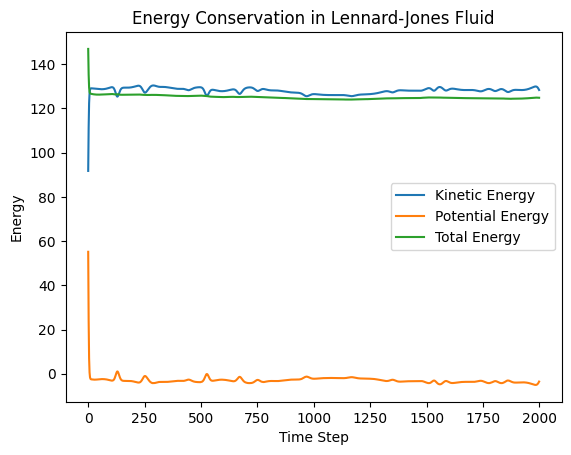

In [7]:
# Main simulation loop
positions = apply_pbc(positions, L)  # Ensure initial positions are within the box.
forces, potential_energy = compute_forces_and_energy(positions)  # Calculate initial forces and energy.
kinetic_energies = []  # List to store kinetic energy at each time step.
potential_energies = []  # List to store potential energy at each time step.

for step in range(steps):
    # Update positions, velocities, and forces using Velocity Verlet
    positions, velocities, forces, potential_energy = velocity_verlet(positions, velocities, forces)

    # Calculate kinetic energy: (1/2)mv^2 for all particles
    kinetic_energy = 0.5 * mass * np.sum(velocities**2)
    kinetic_energies.append(kinetic_energy)
    potential_energies.append(potential_energy)

    # Output energy information every 100 steps
    if step % 100 == 0:
        print(f"Step {step}: Total Energy = {kinetic_energy + potential_energy:.3f}")

# Plot energy results
import matplotlib.pyplot as plt

plt.figure()
plt.plot(kinetic_energies, label='Kinetic Energy')
plt.plot(potential_energies, label='Potential Energy')
plt.plot(np.array(kinetic_energies) + np.array(potential_energies), label='Total Energy')
plt.xlabel('Time Step')
plt.ylabel('Energy')
plt.legend()
plt.title('Energy Conservation in Lennard-Jones Fluid')
plt.show()

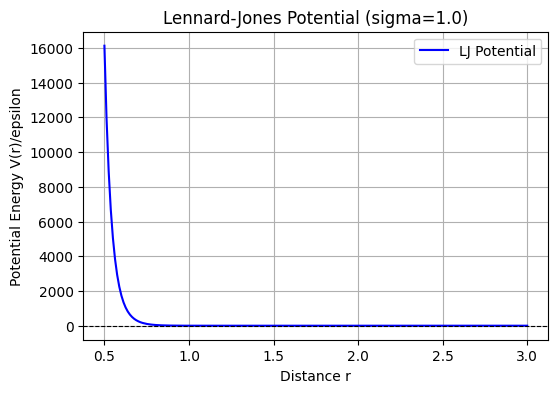

In [8]:
# Lennard-Jones plot
# Define the Lennard-Jones potential function
def lj_potential(r, sigma):
    """
    Computes the Lennard-Jones potential for distance r,
    with parameters sigma and epsilon.
    """
    # To prevent division by zero if r is extremely small, return infinity
    if r <= 0:
        return np.inf
    
    r_inv = sigma / r
    r_inv6 = r_inv**6
    r_inv12 = r_inv6**2
    return 4.0 * (r_inv12 - r_inv6)

# Range of r values for which to evaluate the LJ potential
r_min = 0.5  # Start from some small distance (units of sigma)
r_max = 3.0  # Go out to a few sigma
num_points = 200

r_values = np.linspace(r_min, r_max, num_points)
lj_values = [lj_potential(r, sigma) for r in r_values]

# Plot the Lennard-Jones potential
plt.figure(figsize=(6,4))
plt.plot(r_values, lj_values, label='LJ Potential', color='blue')

# Optional: zero reference line
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')

# Labeling and styling
plt.xlabel("Distance r")
plt.ylabel("Potential Energy V(r)/epsilon")
plt.title("Lennard-Jones Potential (sigma=1.0)")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


Animation saved as 'simulation.gif'


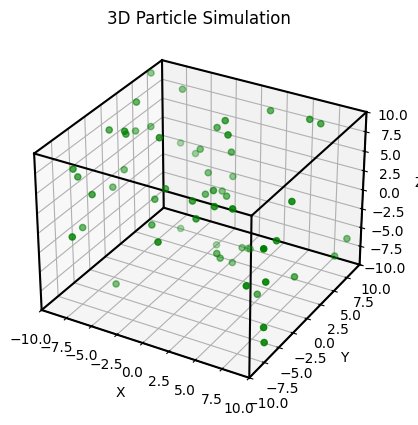

In [10]:
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image

# Function to animate particles and save as a GIF
def animate_box(positions_over_time, L):
    """
    Creates an animation of particles in the simulation box and saves it as a GIF.

    Parameters:
    - positions_over_time: List of particle positions at each timestep.
    - L: Simulation box size (assumed cubic, so it's L x L x L).
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot for particle positions
    scatter = ax.scatter([], [], [], c='g', marker='o', s=20)

    # Draw the simulation box edges
    edges = [
        [[-L/2, -L/2, -L/2], [-L/2, -L/2, L/2]],
        [[-L/2, -L/2, -L/2], [-L/2, L/2, -L/2]],
        [[-L/2, -L/2, -L/2], [L/2, -L/2, -L/2]],
        [[-L/2, -L/2, L/2], [-L/2, L/2, L/2]],
        [[-L/2, -L/2, L/2], [L/2, -L/2, L/2]],
        [[-L/2, L/2, -L/2], [-L/2, L/2, L/2]],
        [[-L/2, L/2, -L/2], [L/2, L/2, -L/2]],
        [[-L/2, L/2, L/2], [L/2, L/2, L/2]],
        [[L/2, -L/2, -L/2], [L/2, -L/2, L/2]],
        [[L/2, -L/2, -L/2], [L/2, L/2, -L/2]],
        [[L/2, -L/2, L/2], [L/2, L/2, L/2]],
        [[L/2, L/2, -L/2], [L/2, L/2, L/2]],
    ]
    for edge in edges:
        ax.plot(*zip(*edge), c='k')  # Draw each edge of the box.

    # Set axis limits and labels
    ax.set_xlim(-L / 2, L / 2)
    ax.set_ylim(-L / 2, L / 2)
    ax.set_zlim(-L / 2, L / 2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Particle Simulation')

    # Update function for the animation
    def update(frame):
        scatter._offsets3d = (
            positions_over_time[frame][:, 0],
            positions_over_time[frame][:, 1],
            positions_over_time[frame][:, 2]
        )
        return scatter,

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(positions_over_time), interval=50, blit=False)

    # Save the animation as a GIF
    ani.save("simulation.gif", writer=PillowWriter(fps=20))

    print("Animation saved as 'simulation.gif'")
    return ani


# Simulated positions over time
positions_over_time = []  # Initialize list to store positions at each step
positions = apply_pbc(positions, L)  # Ensure initial positions are inside the box
forces, potential_energy = compute_forces_and_energy(positions)  # Initial forces

for step in range(steps):
    positions, velocities, forces, potential_energy = velocity_verlet(positions, velocities, forces)
    positions_over_time.append(positions.copy())  # Store positions for animation

# Call the function to save the animation
ani = animate_box(positions_over_time, L)